# Import Python Libraries

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
from scipy import signal 
import pandas as pd
import nept
import metakernel; metakernel.register_ipython_magics()
from get_neuralynx import *
from robust_stats import *
from FilterCSCs import *
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

/Users/alexgonzalez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'FilterCSCs'

In [2]:
def sig_hist(signal):
    num_bins = 1000
    fig, ax = plt.subplots(figsize=(6,4))
    n, bins, patches = ax.hist(signal[~np.isnan(signal)], num_bins, normed=1, facecolor='blue', alpha=0.5)
    ax.set(xlabel='Amplitude[uV]', ylabel='Probability',
           title='Data Distribution for Chan '+channel)
    ax.set_xlim(np.nanpercentile(signal,[0.1,99.9]))
    return fig,ax

# Filter Design (Matlab)

``` OCTAVE
fs = 32000; % sampling rate
Ny = fs/2;  % nyquist
fOrder = 64;

% initial iir filt
[b0,a] = cheby1(4,0.001,300/Ny,'high');

b_lowpass =  fir1(fOrder, [6500]/Ny,kaiser(fOrder+1,8));
b_highpass=  fir1(fOrder*4, [150]/Ny,'high',blackman(fOrder*4+1));

% form equivalent filter
beq=conv(conv(b0,b_lowpass),b_highpass);
% plot
fvtool(beq,a,b0,a,b_lowpass,1,b_highpass,1,'fs',fs)
% save
dlmwrite('filt_a.dat',a,'delimiter',',','precision',12)
dlmwrite('filt_b.dat',beq,'delimiter',',','precision',12)

```

The above matlab code creates an IIR Filter. The code was run and the filter coefficients saved.

In [7]:
beq = np.fromfile('filt_b.dat',dtype='float',sep=',')
a = np.fromfile('filt_a.dat',dtype='float',sep=',')

w, h = signal.freqz(beq,a,)

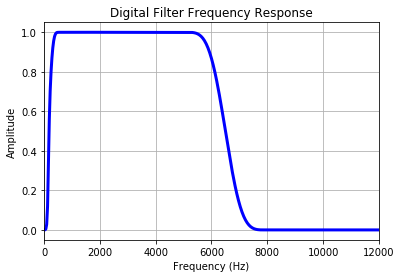

In [4]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(w/np.pi*16000, abs(h), 'b',linewidth=3)
ax.set(xlabel='Frequency (Hz)', ylabel='Amplitude',
       title='Digital Filter Frequency Response',xlim=(0,12000))
ax.grid()


### Load a signal and filter

In [8]:
dataDir = '/Users/alexgonzalez/Google Drive/PostDoc/Data/'
animal = 'Li'
task = 'T3g'
date = '060418'
channel = '1b'
FolderName = animal+'_'+task+'_'+date
FileName  = 'CSC'+channel+'.ncs'
fn = dataDir+FolderName+'/'+FileName

sig = nept.load_lfp(fn)
sig.data = np.float32(sig.data.flatten()*1e6)

(<matplotlib.figure.Figure at 0x1c1fb043c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1fb04be0>)

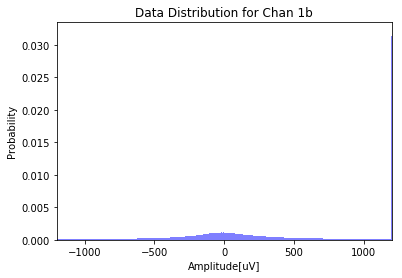

In [6]:
sig_hist(sig.data)

In [10]:
info = {'fn':FolderName+'/'+FileName,'nSamps':len(sig.data),'filt_b_coef':beq,'filt_a_coef':a}
h=get_header(fn)
info={**info,**h}

In [15]:
t1=time.time()
#filtdat = signal.filtfilt(beq,a,sig.data).astype(np.float32)
filtdat = FilterCSC(sig.data,info)
t2=time.time()
print('Time to filter = %0.2f' % (t2-t1))

Time to filter = 51.78


In [48]:
f, Pxx_den = signal.welch(sig.data, 32000, nperseg=1024)
f, Pyy_den = signal.welch(filtdat, 32000, nperseg=1024)

(1e-18, 1e-09)

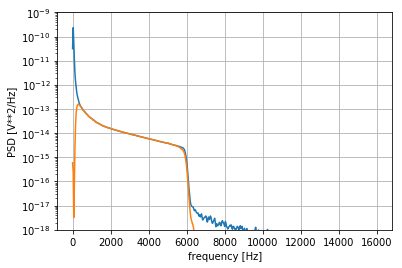

In [59]:
fig, ax = plt.subplots(figsize=(6,4))
ax.semilogy(f, Pxx_den)
ax.semilogy(f,Pyy_den)
#plt.ylim([0.5e-3, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.grid()
#ax.set_xlim(-100,2000)
ax.set_ylim(10e-19,10e-10)
#ax.set_ylim(0,1e-12)

In [18]:
info['AmpPercentileThr']=0.975
t1=time.time()
filtdat, info = AmpRej(filtdat,info)
t2=time.time()
print('Time to reject samples above %0.2f uV =  %0.2f seconds'%(info['AmpRejThr'],t2-t1))
print('Number of samples rejected = %f' % info['nBadAmpSamps'] )

Time to reject samples above 1170.00 uV =  0.63 seconds
Number of samples rejected = 0.000000


/Users/alexgonzalez/Google Drive/PostDoc/Code/PreProcessing/FilterCSCs.py:16: RuntimeWarning: invalid value encountered in greater_equal
  badSamps=np.where(abs(signal)>=info['AmpRejThr'])[0]


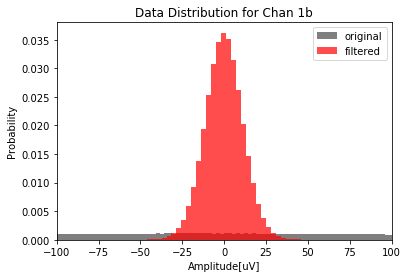

In [24]:
num_bins = 1000
fig, ax = plt.subplots(figsize=(6,4))
n, bins, patches = ax.hist(sig.data, num_bins, normed=1, facecolor='black', alpha=0.5)
n, bins, patches = ax.hist(filtdat[~badSamps], num_bins, normed=1, facecolor='red', alpha=0.7)
ax.set(xlabel='Amplitude[uV]', ylabel='Probability',
       title='Data Distribution for Chan '+channel)
ax.set_xlim(-100,100)
ax.legend(['original','filtered'])

In [19]:
# standarize data
#z = (filtdat-np.nanmedian(filtdat))/(mad(filtdat)*1.4826)
z = robust_zscore(filtdat)


NameError: name 'filtdat' is not defined

In [13]:
fn

'/Users/alexgonzalez/Google Drive/PostDoc/Data/Li_T3g_060418/CSC1b.ncs'

In [35]:
h

{'AD': array(3.66210937e-08),
 'ChanID': 1,
 'InputRange': 1200,
 'RefChan': 19,
 'fs': 32000}

In [ ]:
hh=nept.load_neuralynx_header(fn)

In [4]:
dataDir = '/Users/alexgonzalez/Google Drive/PostDoc/Data/'
animal = 'Li'
task = 'T3g'
date = '060418'
channel = '1b'
FolderName = animal+'_'+task+'_'+date
FileName  = 'CSC'+channel+'.ncs'
fn = dataDir+FolderName+'/'+FileName
h=get_header(fn)

{'AD': array(3.66210937e-08),
 'ChanID': 1,
 'InputRange': 1200,
 'RefChan': 19,
 'fs': 32000}